In [1]:
import pandas as pd
import numpy as np

# modeling
import keras
from keras.utils import pad_sequences
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

2025-02-22 10:46:56.849208: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Expects: run the code on lstm_traffic_only_1 to generate the csv info

traffic_df = pd.read_csv("../data/traffic_pre_lstm.csv")
traffic_df['timestamp'] = pd.to_datetime(traffic_df['timestamp'])
traffic_df.set_index('timestamp', inplace=True)
traffic_df.head()

,610,611,612,613,614,615,616,617,618,619,...,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-01 08:10:00,41.0,0.0,52.0,38.0,40.0,86.0,62.0,44.0,40.0,23.0,...,16.0,20.0,21.0,50.0,19.0,48.0,34.0,0.0,65.0,32.000000
2014-08-01 08:15:00,41.0,0.0,52.0,40.0,40.0,86.0,62.0,45.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,69.0,34.0,0.0,69.0,32.000000
2014-08-01 08:20:00,41.0,0.0,61.0,44.0,40.0,33.0,75.0,49.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,70.0,36.0,0.0,67.0,28.000000
2014-08-01 08:25:00,41.0,0.0,61.0,45.0,40.0,33.0,59.0,53.0,44.0,23.0,...,22.0,37.0,21.0,57.0,22.0,56.0,46.0,0.0,58.0,28.000000
2014-08-01 08:30:00,41.0,0.0,38.0,43.0,40.0,77.0,59.0,47.0,36.0,23.0,...,22.0,23.0,14.0,57.0,22.0,51.0,46.0,0.0,60.0,27.666667


In [3]:
traffic_df.shape

(29984, 449)

## Adding weather features

In [47]:
weather_df = pd.read_csv("../data/aarhus_weather_data_combined.csv")
weather_df["Datetime"] = pd.to_datetime(weather_df["Datetime"])
weather_df.set_index("Datetime", inplace=True, drop=True)

# merge with a complete timestamp index
timestamp_index = pd.DataFrame({"timestamp": pd.date_range(pd.to_datetime(
    weather_df.index.min()), pd.to_datetime(weather_df.index.max()), freq="5min").to_list()})

weather_df = timestamp_index.merge(
    weather_df,
    how="left",
    left_on="timestamp",
    right_index=True
)
weather_df.set_index("timestamp", inplace=True)

# impute missing values using linear interpolation
weather_df.interpolate(method="linear", inplace=True)


weather_features = ["pressurem", "tempm", "vism", "wspdm"]

combined_weather_traffic = traffic_df.merge(
    weather_df[weather_features],
    how="left",
    left_index=True,
    right_index=True
)

# remove rows at the end without occupancy data
combined_weather_traffic = combined_weather_traffic[combined_weather_traffic["wspdm"].notna()]

combined_weather_traffic

,610,611,612,613,614,615,616,617,618,619,...,1053,1054,1055,1056,1057,1058,pressurem,tempm,vism,wspdm
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-01 08:10:00,41.0,0.0,52.0,38.0,40.0,86.0,62.0,44.0,40.0,23.0,...,19.0,48.0,34.0,0.0,65.0,32.000000,1012.500000,19.500000,10.0,8.350000
2014-08-01 08:15:00,41.0,0.0,52.0,40.0,40.0,86.0,62.0,45.0,40.0,23.0,...,21.0,69.0,34.0,0.0,69.0,32.000000,1012.250000,19.750000,10.0,7.875000
2014-08-01 08:20:00,41.0,0.0,61.0,44.0,40.0,33.0,75.0,49.0,40.0,23.0,...,21.0,70.0,36.0,0.0,67.0,28.000000,1012.000000,20.000000,10.0,7.400000
2014-08-01 08:25:00,41.0,0.0,61.0,45.0,40.0,33.0,59.0,53.0,44.0,23.0,...,22.0,56.0,46.0,0.0,58.0,28.000000,1012.000000,20.166667,10.0,8.016667
2014-08-01 08:30:00,41.0,0.0,38.0,43.0,40.0,77.0,59.0,47.0,36.0,23.0,...,22.0,51.0,46.0,0.0,60.0,27.666667,1012.000000,20.333333,10.0,8.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-30 23:30:00,47.0,0.0,42.0,40.0,45.0,18.0,69.0,51.0,33.0,24.0,...,0.0,95.0,39.0,41.0,94.0,43.000000,1025.666667,14.000000,10.0,14.800000
2014-09-30 23:35:00,47.0,0.0,42.0,40.0,45.0,18.0,69.0,51.0,33.0,24.0,...,0.0,87.0,39.0,41.0,94.0,43.000000,1025.500000,14.000000,10.0,14.800000
2014-09-30 23:40:00,47.0,0.0,42.0,40.0,45.0,18.0,69.0,51.0,33.0,24.0,...,0.0,79.0,39.0,41.0,94.0,43.000000,1025.333333,14.000000,10.0,14.800000


In [50]:
training_sample = combined_weather_traffic[100:14000]
validation_sample = combined_weather_traffic[14001:]

validation_sample.shape

(3468, 453)

In [51]:
def create_sequence_training_set(training_sample, seq_length, pred_horizon, input_features, output_features):
    seq_arrays = []
    seq_labs = []
    for i in range(training_sample.shape[0] - seq_length - pred_horizon):
        seq_arrays.append(training_sample.iloc[i:seq_length+i, :input_features].to_numpy())
        seq_labs.append(training_sample.iloc[seq_length+pred_horizon+i, :output_features])

    seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
    seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)
    return seq_arrays, seq_labs

# create validation dataset
def create_validation_set(validation_sample, seq_length, pred_horizon, input_features, output_features):
    val_arrays = []
    val_labs = []
    for i in range(validation_sample.shape[0] - seq_length - pred_horizon):
        if i < seq_length:
            val_arrays.append(validation_sample.iloc[:(i+1), :input_features].to_numpy())
            val_labs.append(validation_sample.iloc[:(i+pred_horizon+1), :output_features].to_numpy()[-1])
        else:
            val_arrays.append(validation_sample.iloc[i:seq_length+i, :input_features].to_numpy())
            val_labs.append(validation_sample.iloc[seq_length+i+pred_horizon, :output_features])

    val_arrays = pad_sequences(val_arrays, padding='pre', dtype=object).astype(np.float32)
    val_labs = np.array(val_labs, dtype=object).astype(np.float32)
    return val_arrays, val_labs


In [52]:
# set predictive horizon and sequence length
ph = 5
seq_length = 12

# features to randomly sample without replacement
# must be a value between 1 to 453, inclusive 

input_features = 453 
output_features = 449

sensor = pd.Series(training_sample.columns).sample(
    input_features, replace=False).sort_values().to_list()


seq_arrays, seq_labs = create_sequence_training_set(training_sample, seq_length, ph,input_features, output_features)

val_arrays, val_labs = create_validation_set(validation_sample, seq_length, ph, input_features, output_features)

In [61]:
def train_lstm_model(model_path, seq_length, seq_arrays, seq_labs, input_features, output_features):
# define path to save model
    model_path = model_path

    # build the network
    output_size = output_features

    model = Sequential()

    model.add(LSTM(
        input_shape=(seq_length, input_features), 
        units=100, activation="relu", return_sequences=True))
    model.add(Dropout(0.025))

    model.add(LSTM(units=64, activation="relu", return_sequences=True))
    model.add(Dropout(0.025))
    model.add(LSTM( units=32, activation="relu", return_sequences=False))
    model.add(Dense(units=output_size, activation="linear"))

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

    print(model.summary())

    # fit the network
    history = model.fit(seq_arrays,
                    seq_labs,
                    epochs=1000,
                    batch_size=80,
                    validation_split=0.05,
                    verbose=2,
                    callbacks=[
                        keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.1,
                            patience=5,
                            verbose=0,
                            mode='min'),
                        keras.callbacks.ModelCheckpoint(
                            model_path,
                            monitor='val_loss',
                            save_best_only=True,
                            mode='min',
                            verbose=0)
                    ])

    return model, history



In [62]:
model, history = train_lstm_model('lstm_traffic_weather.keras',
                                  seq_length,
                                  seq_arrays,
                                  seq_labs,
                                  input_features, 
                                  output_features)
# list all data in history
print(history.history.keys())

/opt/anaconda3/envs/usd_ai/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 100)        │       221,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 449)            │        14,817 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,073 (1.11 MB)

 Trainable params: 291,073 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
165/165 - 8s - 47ms/step - loss: 3326.0129 - mse: 3326.0129 - val_loss: 186.0466 - val_mse: 186.0466
Epoch 2/1000
165/165 - 4s - 26ms/step - loss: 230.1477 - mse: 230.1477 - val_loss: 156.1316 - val_mse: 156.1316
Epoch 3/1000
165/165 - 5s - 31ms/step - loss: 179.9598 - mse: 179.9598 - val_loss: 153.7213 - val_mse: 153.7213
Epoch 4/1000
165/165 - 5s - 32ms/step - loss: 171.2111 - mse: 171.2111 - val_loss: 154.1323 - val_mse: 154.1323
Epoch 5/1000
165/165 - 6s - 35ms/step - loss: 164.3411 - mse: 164.3411 - val_loss: 154.1448 - val_mse: 154.1448
Epoch 6/1000
165/165 - 6s - 33ms/step - loss: 161.9273 - mse: 161.9273 - val_loss: 154.0466 - val_mse: 154.0466
Epoch 7/1000
165/165 - 6s - 38ms/step - loss: 160.2150 - mse: 160.2150 - val_loss: 151.2348 - val_mse: 151.2348
Epoch 8/1000
165/165 - 6s - 34ms/step - loss: 158.7468 - mse: 158.7468 - val_loss: 155.9920 - val_mse: 155.9920
Epoch 9/1000
165/165 - 5s - 30ms/step - loss: 157.6470 - mse: 157.6470 - val_loss: 157.1875 - val

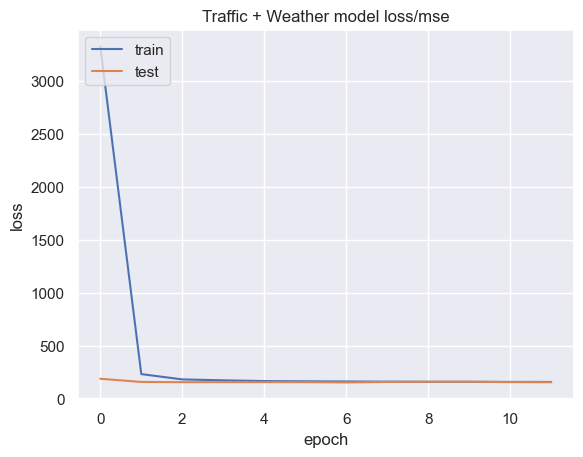

108/108 - 1s - 9ms/step - loss: 186.9663 - mse: 186.9663

MSE: 186.96629333496094


In [63]:
def summarize_history_loss(history, title):
    # summarize history for Loss/MSE
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

summarize_history_loss(history, "Traffic + Weather model loss/mse")

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


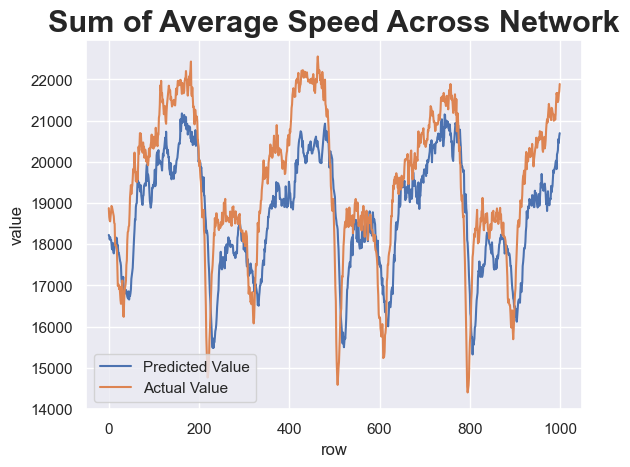

In [66]:
def plot_prediction_across_network(model, val_arrays, val_labs, title):
    y_pred_test = model.predict(val_arrays)
    y_true_test = val_labs

    # aggregating for easier visualization
    y_pred_dv = [row.sum() for row in y_pred_test]
    y_true_dv = [row.sum() for row in y_true_test]

    start = 1000
    ts = 1000

    plt.plot(y_pred_dv[start:start+ts], label='Predicted Value')
    plt.plot(y_true_dv[start:start+ts], label='Actual Value')
    plt.title(title,
            fontsize=22, fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend()
    plt.show()

plot_prediction_across_network(model, val_arrays, val_labs, 'Sum of Average Speed Across Network')